In [1]:
from operator import itemgetter
from os.path import join

import numpy as np
from numpy.random import randn
np.random.seed(42)

from scipy.io import loadmat

# pinv2 is closest to matlab pinv (ie it uses svd)
from scipy.linalg import svd, fractional_matrix_power, pinv2 as pinv

# Python control toolbox available at https://python-control.readthedocs.io/
from control import ss, use_numpy_matrix
from control.matlab import impulse as impulse_, lsim
use_numpy_matrix(False)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [2]:
def impulse(sys, T, return_x=False):
    """
    Simplified version of existing routine (impulse_) but handles multiple inputs
    """
    _, q = sys.B.shape
    responses = [impulse_(sys, T=T, input=qi, return_x=return_x) for qi in range(q)]
    # "transpose" over first two axes to expose returned tuple
    ys, ts, *xs = map(list, zip(*responses))
    # move new inputs axis to the end
    ys = np.moveaxis(ys, 0, -1)
    # times are common
    ts = np.array(ts[0])
    # xs will be non-empty iff return_x was True
    return (ys, ts, np.moveaxis(xs[0], 0, -1)) if return_x else (ys, ts)

In [3]:
q = 2   # Number of inputs
p = 2   # Number of outputs
n = 100 # State dimension
r = 10  # Order of reduced model

test_sys = loadmat(join('..', 'DATA', 'testSys_ABCD.mat'))
A, B, C, D = itemgetter(*'ABCD')(test_sys)

# Setting dt implies a discrete system
sys_full = ss(A, B, C, D, 1.0)

In [4]:
# Impulse response of full system
ntimes = 5*r + 2

# Arranged (ntimes, p,  q) 
y_full, _ = impulse(sys_full, T=np.arange(ntimes))

# Reorder axes from (ntimes, p, q) to (p, q, ntimes)
YY = np.moveaxis(y_full, 0, -1)

In [5]:
def hankel(Y, m, n, offset=0):
    """
    Hankel matrix from impulse responses.
    
    Assembled as block matrix of values for multiple input, outputs pairs 

    Parameters
    ----------
    Y: rank 3 ndarray
        impulse responses (noutputs, ninputs, ntimes)
    m, n: int
        (block) shape of Hankel matrix
    offset: int
        shifted Hankel matrix if not zero

    Returns
    -------
    ndarray (m*noutputs, n*ninputs)
    (n, m) stamps of the (noutputs, ninputs) input/output pairs

    """
    assert offset >= 0
    ntimes = Y.shape[2]
    assert m+n-2 + offset < ntimes
    return np.block(
        [[Y[:, :, i+j+offset] for j in range(n)] for i in range(m)]
    )

In [6]:
def era(YY, m, n, r):
    """
    Eigensystem Realisation Algorithm.

    Parameters
    ----------
    YY: rank 3 ndarray
        impulse responses (noutputs, ninputs, ntimes) 
    m, n: int
        (block) shape of Hankel matrix
    r: int
        effective system order - dimensions of reduced model

    Returns
    -------
    tuple:
         reduced order system and Hankel singular values: A, B, C, D, S
    """
    power = fractional_matrix_power

    noutputs, ninputs, ntimes = YY.shape

    # Split off first time point as D̃
    D, Y = YY[:, :, 0], YY[:, :, 1:]
    
    H, H2 = hankel(Y, m, n), hankel(Y, m, n, offset=1)
    U, S, VT = svd(H, full_matrices=False)
    V = VT.T

    Σ = np.diag(S[:r])
    Ũ = U[:, :r]
    Ṽ = V[:, :r]

    A = power(Σ, -1/2) @ Ũ.T @ H2 @ Ṽ @ power(Σ, -1/2)
    B = power(Σ, -1/2) @ Ũ.T @ H[:, :ninputs]
    C = H[:noutputs, :] @ Ṽ @ power(Σ, -1/2)

    return A, B, C, D, S

In [7]:
def okid(y, u, r):
    """
    Observer Kalman Filter Identification.

    lowercase u,y indicate sampled data
    double uppercase UU, YY indicate bold-faced quantities in paper
    single uppercase U, Y indicate script quantities in paper

    Parameters
    ----------
    y: ndarray rank 2
        sampled output (poutputs, msamples)
    u: ndarray rank 2
        sampled input (qinputs, msamples)
    r: int
        effective system order

    Returns
    -------
        Markov parameters H (poutputs, qinputs, (l+1))
    """
    p, m = y.shape
    q, m_u = u.shape
    assert m == m_u
    
    # Choose impulse length l to be  4 or 5 times the effective system order
    l = 5*r
    
    # Construct data matrix V
    V = np.zeros((q + (q + p)*l, m))
    V[:q, :] = u
    for i in range(1, l+1):
        for j in range(m - i):
            V[
                q + (i-1)*(q + p): q + i*(q + p),
                i + j
            ] = np.concatenate((u[:, j], y[:, j]))

    # Solve for observer Markov parameters Ȳ
    Ȳ = y @ pinv(V, rcond=1e-3)

    # Isolate system Markov parameters H
    # NB feed-through term (or D matrix) is the first term
    D = Ȳ[:, :q] 
    Ȳ = Ȳ[:, q:] 

    Ȳ_1 = np.empty((p, q, l))
    Ȳ_2 = np.empty((p, q, l))
    for i in range(l):
        k = i*(q + p)
        Ȳ_1[:, :, i] = Ȳ[:, k: k + q]
        Ȳ_2[:, :, i] = Ȳ[:, k + q: k + q + p]
    
    Y = np.empty((p, q, l))
    Y[:, :, 0] = Ȳ_1[:, :, 0] + Ȳ_2[:, :, 0] @ D
    for k in range(1, l):
        Y[:, :, k] = Ȳ_1[:, :, k] + Ȳ_2[:, :, k] @ D
        for i in range(k):
            Y[:, :, k] += Ȳ_2[:, :, i] @ Y[:, :, k-i-1]
   
    return np.concatenate([D[:, :, np.newaxis],  Y[:, :, :l]], axis=2)

In [8]:
# ERA from impulse response
# m_c = m_o = (m-1)/2
mco = (len(y_full) - 1) // 2
Ã, B̃, C̃, D̃, HSVs = era(YY, mco, mco, r)

# Setting dt implies a discrete system cf -1 in matlab
sys_era = ss(Ã, B̃, C̃, D̃, 1.0)

In [9]:
# Random input simulation for OKID
nsamples = 200

# Random forcing input
u_random = randn(q, nsamples)

# Corresponding output
y_random = lsim(sys_full, u_random, np.arange(nsamples))[0].T

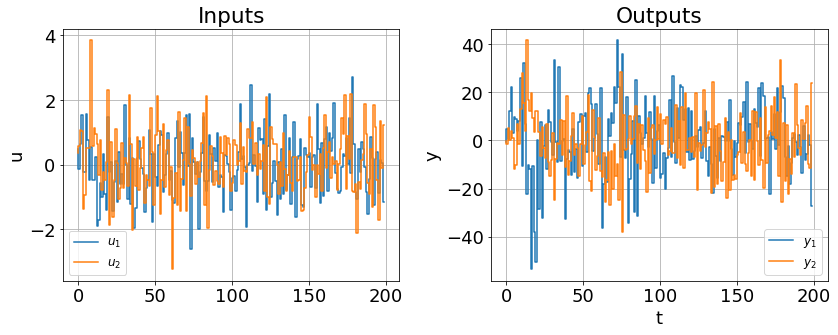

In [10]:
# Figure 9.6

# Plot input/output pair for OKID
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axs[0].set_title('Inputs')
axs[0].step(range(u_random.shape[1]), u_random[0, :], label='$u_1$')
axs[0].step(range(u_random.shape[1]), u_random[1, :], label='$u_2$')
axs[0].set_ylabel('u')

axs[1].set_title('Outputs')
axs[1].step(range(y_random.shape[1]), y_random[0, :], label='$y_1$')
axs[1].step(range(y_random.shape[1]), y_random[1, :], label='$y_2$')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

for ax in axs:
    ax.legend(prop={'size': 12})
    ax.grid(True)
plt.tight_layout()

In [11]:
# OKID and then ERA
H = okid(y_random, u_random, r)

mco = (H.shape[2] - 1) // 2
Ã, B̃, C̃, D̃, HSVs = era(H, mco, mco, r)

sys_era_okid = ss(Ã, B̃, C̃, D̃, 1.0)

In [12]:
# Impulse responses for all methods
ntimes = 101
y1, t1 = impulse(sys_full, np.arange(ntimes))
y2, t2 = impulse(sys_era, np.arange(ntimes))
y3, t3 = impulse(sys_era_okid, np.arange(ntimes))

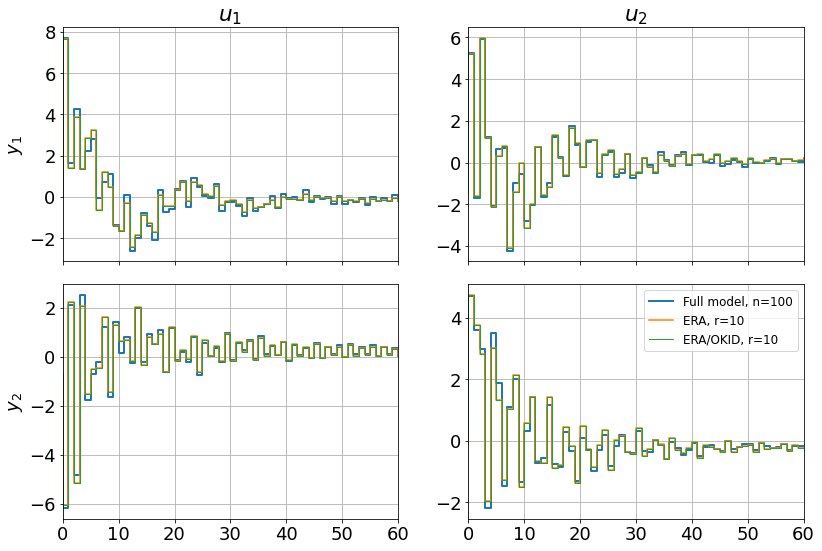

In [13]:
# Figure 9.7
  
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
axs = axs.flat

axs[0].step(t1, y1[:, 0, 0], linewidth=2)
axs[0].step(t2, y2[:, 0, 0], linewidth=1.5)
axs[0].step(t3, y3[:, 0, 0], linewidth=1)
axs[0].set_ylabel('$y_1$')
axs[0].set_title('$u_1$')

axs[1].step(t1, y1[:, 0, 1], linewidth=2)
axs[1].step(t2, y2[:, 0, 1], linewidth=1.5)
axs[1].step(t3, y3[:, 0, 1], linewidth=1)
axs[1].set_title('$u_2$')

axs[2].step(t1, y1[:, 1, 0], linewidth=2)
axs[2].step(t2, y2[:, 1, 0], linewidth=1.5)
axs[2].step(t3, y3[:, 1, 0], linewidth=1)
axs[2].set_ylabel('$y_2$')

axs[3].step(t1, y1[:, 1, 1], linewidth=2, label=f'Full model, n={n}')
axs[3].step(t2, y2[:, 1, 1], linewidth=1.5, label=f'ERA, r={r}')
axs[3].step(t3, y3[:, 1, 1], linewidth=1, label=f'ERA/OKID, r={r}')
axs[3].legend(prop={'size': 12})

# Zoom in on just the first 60 time points of reponses
for ax in axs:
    ax.set_xlim(0, 60)
    ax.grid(True)
plt.tight_layout()